# TabTransformers
In this notebook I will be deploying the TabTransformers model on the IBLI dataset

https://huggingface.co/keras-io/tab_transformer

In [22]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns

from scipy.stats import f_oneway
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow import keras
from tensorflow import metrics
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, LayerNormalization, MultiHeadAttention, Add, Lambda, Dropout
from tensorflow.keras.models import Model
import keras_tuner as kt
from keras.metrics import MeanSquaredError, MeanAbsoluteError

In [23]:
keras.metrics.R2Score(
    class_aggregation="uniform_average", num_regressors=0, name="r2_score", dtype=None
)

<R2Score name=r2_score>

# Load and preprocess the data

In [37]:
#Load in the dataset
df = pd.read_excel("C:/Users/daanm/Documents/Universiteit Utrecht/Scriptie/goat_df.xlsx")
df = df.drop(['Unnamed: 0','advise_vip','purchase_bin','cs_cs_ratio_post_goat','buy_nr_goat','buy_goat', 'ratio_insured_goat', 'n_previd_goat','wave', 'id'], axis=1)
df.head()

,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_goat,number_minors,...,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip
0,No,25,Yes,No,Never attended,No,0,1,-120.671875,2,...,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes
1,Yes,27,Yes,No,Adult Education,No,0,0,-758.621033,2,...,Not working,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes
2,Yes,29,No,No,Elementary,No,1,0,-1180.266846,2,...,Working with Livestock,Fully settled: The whole of the household (all...,2,Professional and Organizational Sources,Christian,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes
3,No,35,Yes,No,Never attended,No,0,0,-53.165897,3,...,Student,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes
4,No,36,Yes,No,Never attended,No,1,1,-513.432312,3,...,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes


In [38]:
columns_list = df.columns.tolist()
print(columns_list)


['afm_language', 'age_constant', 'agric_land', 'amh_language', 'educ_recoded_constant', 'eng_language', 'expend', 'irrigated_land_bin', 'cs_cs_diff_post_goat', 'number_minors', 'educ_child_recoded', 'activity_child_recoded', 'household_description', 'number_adults', 'main_info_source_recoded', 'religion_recoded', 'owns_phone', 'household_moved', 'why_not_purchase_recoded', 'know_vip', 'trust_vip']


In [39]:
#Log+1 transforming the dataset to improve the distribution

df['cs_diff_log'] = np.log(np.abs(df['cs_cs_diff_post_goat']) + 1)
df[['cs_cs_diff_post_goat', 'cs_diff_log']].head()

,cs_cs_diff_post_goat,cs_diff_log
0,-120.671875,4.801328
1,-758.621033,6.632820
2,-1180.266846,7.074343
3,-53.165897,3.992052
4,-513.432312,6.243064


In [40]:
y = df['cs_diff_log']
X = df.drop(columns=['cs_diff_log', 'cs_cs_diff_post_goat'])

In [42]:
categorical = X.select_dtypes(include=['object','category']).columns.tolist()
numerical = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Deploy the TabTransformers model
The following website has been used as a guide for this implementation:

https://keras.io/examples/structured_data/tabtransformer/

In [43]:
#Encode and scale the data

label_encoders = {}
for col in categorical:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

scaler = StandardScaler()
X[numerical] = scaler.fit_transform(X[numerical])

In [44]:
# Inputs
inputs = []
embeddings = []

# Embedding categorical features
for col in categorical:
    input_cat = Input(shape=(1,), name=col)
    vocab_size = X[col].nunique()
    embed_dim = min(50, (vocab_size + 1) // 2)
    
    embedding = layers.Embedding(input_dim=vocab_size + 1, output_dim=embed_dim)(input_cat)
    embedding = layers.Reshape((embed_dim,))(embedding)
    
    inputs.append(input_cat)
    embeddings.append(embedding)

# Numerical input
input_num = Input(shape=(len(numerical),), name="numerical")
inputs.append(input_num)
embeddings.append(input_num)

# Concatenate all embeddings + numerical
x = layers.Concatenate()(embeddings)

# Project everything to a fixed dimension for transformer block
hidden_dim = 64
x = layers.Dense(hidden_dim)(x)

#Adding a feed forward network to improve the model

def feed_forward_network(hidden_dim, ff_dim, dropout_rate=0.01):
    return tf.keras.Sequential([
        layers.Dense(ff_dim, activation="relu"),   
        layers.Dropout(dropout_rate),
        layers.Dense(hidden_dim)                    
    ])

# Transformer blocks
for _ in range(2):
    x1 = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x1[:, None, :], x1[:, None, :])
    attn_output = layers.Lambda(lambda x: tf.squeeze(x, axis=1))(attn_output)
    attn_output = layers.Dropout(0.1)(attn_output)

    x2 = layers.Add()([x, attn_output])
    
    x3 = layers.LayerNormalization()(x2)
    ffn = feed_forward_network(hidden_dim=hidden_dim, ff_dim=hidden_dim*4)
    ffn_output = ffn(x3)
    x = layers.Add()([x2, ffn_output])

# Output for regression
output = layers.Dense(1)(x)

# Model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.R2Score()])


In [45]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construct TabTransformer input format
def make_tab_input(df, categorical, numerical):
    inputs = {col: df[col].values for col in categorical}
    inputs['numerical'] = df[numerical].values
    return inputs

X_train = make_tab_input(X_train_raw, categorical, numerical)
X_test = make_tab_input(X_test_raw, categorical, numerical)

In [46]:
X_train = {
    col: X_train_raw[col].values for col in categorical
}
X_train["numerical"] = X_train_raw[numerical].values

# Same for X_test
X_test = {
    col: X_test_raw[col].values for col in categorical
}
X_test["numerical"] = X_train_raw[numerical].values

In [47]:
model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 6.3258 - mean_absolute_error: 1.8148 - r2_score: -1.7945 - val_loss: 2.3134 - val_mean_absolute_error: 1.1889 - val_r2_score: -0.0481
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3707 - mean_absolute_error: 1.1773 - r2_score: -0.1447 - val_loss: 2.3779 - val_mean_absolute_error: 1.2009 - val_r2_score: -0.0773
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4001 - mean_absolute_error: 1.1959 - r2_score: -0.0812 - val_loss: 2.7394 - val_mean_absolute_error: 1.3416 - val_r2_score: -0.2411
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4816 - mean_absolute_error: 1.2221 - r2_score: -0.1326 - val_loss: 2.2555 - val_mean_absolute_error: 1.1685 - val_r2_score: -0.0218
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3577 - mean_absolute_error: 1.1691 - r2_score: -0.0190 - val_loss: 2.2656 - val_mean_absolute_error: 1.1358 - val_r2_score: -0.0264
Epoch 6/10
100/100 ━━━━━

# Hyperparameter tuning
using https://keras.io/keras_tuner/

In [48]:
def build_model(hp):
    # Hyperparameters
    hidden_dim = hp.Int('hidden_dim', min_value=32, max_value=128, step=32)
    ff_dim = hp.Int('ff_dim', min_value=128, max_value=512, step=32)
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)
    num_heads = hp.Choice('num_heads', [2, 4, 8])
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])

    # Inputs
    inputs = []
    embeddings = []

    for col in categorical:
        input_cat = Input(shape=(1,), name=col)
        vocab_size = X[col].nunique()
        embed_dim = min(50, (vocab_size + 1) // 2)
        embedding = layers.Embedding(input_dim=vocab_size + 1, output_dim=embed_dim)(input_cat)
        embedding = layers.Reshape((embed_dim,))(embedding)
        inputs.append(input_cat)
        embeddings.append(embedding)

    input_num = Input(shape=(len(numerical),), name="numerical")
    inputs.append(input_num)
    embeddings.append(input_num)

    x = layers.Concatenate()(embeddings)
    x = layers.Dense(hidden_dim)(x)

    for _ in range(2):
        x1 = layers.LayerNormalization()(x)
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim // num_heads, dropout=dropout_rate)(
            x1[:, None, :], x1[:, None, :]
        )
        attn_output = layers.Lambda(lambda x: tf.squeeze(x, axis=1))(attn_output)
        x2 = layers.Add()([x, attn_output])

        x3 = layers.LayerNormalization()(x2)
        ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(hidden_dim),
        ])
        ffn_output = ffn(x3)
        x = layers.Add()([x2, ffn_output])

    output = layers.Dense(1)(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse', metrics=[
            keras.metrics.R2Score(name='r2_score'), keras.metrics.MeanSquaredError(name='mse'), keras.metrics.MeanAbsoluteError(name='mae')
        ])
    return model

## RandomSearch

Random search selects combinations of hyperparameters at random from a defined search space. Instead of trying every single possibility, it samples a fixed number of random combinations. This is a faster method and often just as effective as grid search.

In [49]:
tuner = kt.RandomSearch(
    build_model,
    objective= kt.Objective('val_r2_score', direction='max') ,
    max_trials=15,
    executions_per_trial=2,
    directory='tuner_dir_v5',
    project_name='tabtransformer_tuning_v15'
)

tuner.search(X_train, y_train, validation_split=0.2, epochs=15, batch_size=32)

Trial 15 Complete [00h 01m 16s]
val_r2_score: 0.0125197172164917

Best val_r2_score So Far: 0.03356334567070007
Total elapsed time: 00h 21m 38s


In [50]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print(f"Best hidden_dim: {best_hps.get('hidden_dim')}")
print(f"Best ff_dim: {best_hps.get('ff_dim')}")

Best hidden_dim: 128
Best ff_dim: 416


C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Random search results

In [51]:
results = []

for i, trial in enumerate(tuner.oracle.trials.values()):
    hp = trial.hyperparameters.values
    val_r2 = trial.metrics.get_best_value('val_r2_score')
    val_mse = trial.metrics.get_best_value('val_mse')
    val_mae = trial.metrics.get_best_value('val_mae')
    res = {
        'trial_id': trial.trial_id,
        **hp,
        'val_r2_score': val_r2,
        'val_mse': val_mse,
        'val_mae': val_mae
    }
    results.append(res)

results_df = pd.DataFrame(results)

In [52]:
display_cols_r2 = ['trial_id', 'hidden_dim', 'ff_dim', 'dropout_rate', 'num_heads', 'learning_rate', 'val_r2_score','val_mse','val_mae']

#Create a table sorting on the R2 score
results_table_r2 = results_df[display_cols_r2].sort_values(by='val_r2_score', ascending=False)
results_table_r2.style.background_gradient(subset=['val_r2_score'], cmap='viridis_r').background_gradient(subset=['val_r2_score'], cmap='plasma_r')

,trial_id,hidden_dim,ff_dim,dropout_rate,num_heads,learning_rate,val_r2_score,val_mse,val_mae
2,02,128,416,0.200000,8,0.000100,0.033563,2.019538,1.081003
6,06,64,416,0.400000,2,0.001000,0.031468,2.023918,1.083749
5,05,64,288,0.100000,4,0.000100,0.018295,2.051444,1.089713
12,12,64,288,0.200000,4,0.001000,0.017927,2.052213,1.081165
3,03,128,384,0.400000,4,0.001000,0.014417,2.059547,1.097652
7,07,64,288,0.200000,2,0.001000,0.013485,2.061494,1.107410
10,10,96,384,0.300000,2,0.001000,0.012607,2.063331,1.088042
14,14,96,288,0.200000,4,0.001000,0.012520,2.063513,1.096775
13,13,32,128,0.100000,2,0.000100,0.011292,2.066079,1.098824
8,08,64,384,0.100000,8,0.001000,0.008471,2.071974,1.098498


## Hyperband

Hyperband is a so-called bandit-based optimisation algorithm that speeds up hyperparameter search. It tries many configurations quickly using fewer epochs and allocating more resources to the promising candidates.

In [54]:
tuner_v2 = kt.Hyperband(
    build_model,                
    objective= kt.Objective('val_r2_score', direction='max'),   
    max_epochs=50,              
    factor=3,                   
    directory='tuner_dir',      
    project_name='tabtransformer_tuning_v8',
    overwrite=True,             
    seed=42                
)

tuner_v2.search(X_train, y_train, validation_split=0.2, epochs=15, batch_size=32)

Trial 90 Complete [00h 01m 26s]
val_r2_score: 0.022739946842193604

Best val_r2_score So Far: 0.04612463712692261
Total elapsed time: 00h 53m 38s


## Hyperband results

In [55]:
results_hyperband = []

for i, trial in enumerate(tuner_v2.oracle.trials.values()):
    hp = trial.hyperparameters.values
    val_r2 = trial.metrics.get_best_value('val_r2_score')
    val_mse = trial.metrics.get_best_value('val_mse')
    val_mae = trial.metrics.get_best_value('val_mae')
    res = {
        'trial_id': trial.trial_id,
        **hp,
        'val_r2_score': val_r2,
        'val_mse': val_mse,
        'val_mae': val_mae
    }
    results_hyperband.append(res)

results_df_hyperband = pd.DataFrame(results_hyperband)

In [56]:
display_cols_r2 = ['trial_id', 'hidden_dim', 'ff_dim', 'dropout_rate', 'num_heads', 'learning_rate', 'val_r2_score','val_mse','val_mae']

#Create a table sorting on the R2 score
results_table_r2_hyperband = results_df_hyperband[display_cols_r2].sort_values(by='val_r2_score', ascending=False)
results_table_r2_hyperband.style.background_gradient(subset=['val_r2_score'], cmap='viridis_r').background_gradient(subset=['val_r2_score'], cmap='plasma_r')

,trial_id,hidden_dim,ff_dim,dropout_rate,num_heads,learning_rate,val_r2_score,val_mse,val_mae
77,0077,128,128,0.000000,2,0.001000,0.046125,1.993289,1.056283
70,0070,64,416,0.300000,8,0.000100,0.037474,2.011367,1.087821
76,0076,96,192,0.100000,4,0.001000,0.035491,2.015511,1.086128
40,0040,32,224,0.400000,4,0.001000,0.026902,2.033458,1.102806
56,0056,64,384,0.100000,4,0.000100,0.025595,2.036189,1.073621
49,0049,64,448,0.200000,2,0.000100,0.025480,2.036430,1.092965
67,0067,64,384,0.100000,4,0.000100,0.024778,2.037897,1.097154
81,0081,128,416,0.200000,4,0.001000,0.024618,2.038231,1.089415
89,0089,128,160,0.100000,2,0.000100,0.022740,2.042156,1.103824
84,0084,128,416,0.200000,4,0.001000,0.022662,2.042320,1.104292


## Visualizations

In [58]:
from scikeras.wrappers import KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance


In [59]:
X_train_array = list(X_train.values())[0]

In [60]:
best_model = tuner_v2.get_best_models(1)[0]

C:\Users\daanm\anaconda3\envs\jupyter_env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [61]:
from copy import deepcopy
#Extract the permutation importances

def permutation_importance_keras(model, X_dict, y_true, metric=mean_squared_error, n_repeats=5):
    base_score = metric(y_true, model.predict(X_dict))
    importances = {}

    for key in X_dict:
        scores = []

        for _ in range(n_repeats):
            X_permuted = deepcopy(X_dict)
            # Permute the feature
            X_permuted[key] = np.random.permutation(X_permuted[key])
            score = metric(y_true, model.predict(X_permuted))
            scores.append(score)

        # Importance = how much the score gets worse when permuted
        importances[key] = np.mean(scores) - base_score

    return importances

In [62]:
importances = permutation_importance_keras(best_model, X_train, y_train)

sorted_importance = sorted(importances.items(), key=lambda x: x[1], reverse=True)

for feature, score_diff in sorted_importance:
    print(f"{feature}: ΔMSE = {score_diff:.4f}")

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step   
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s

C:\Users\daanm\AppData\Local\Temp\ipykernel_26848\1661738819.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Absolute Coefficient", y="Feature", data=top_features_df, palette="mako")


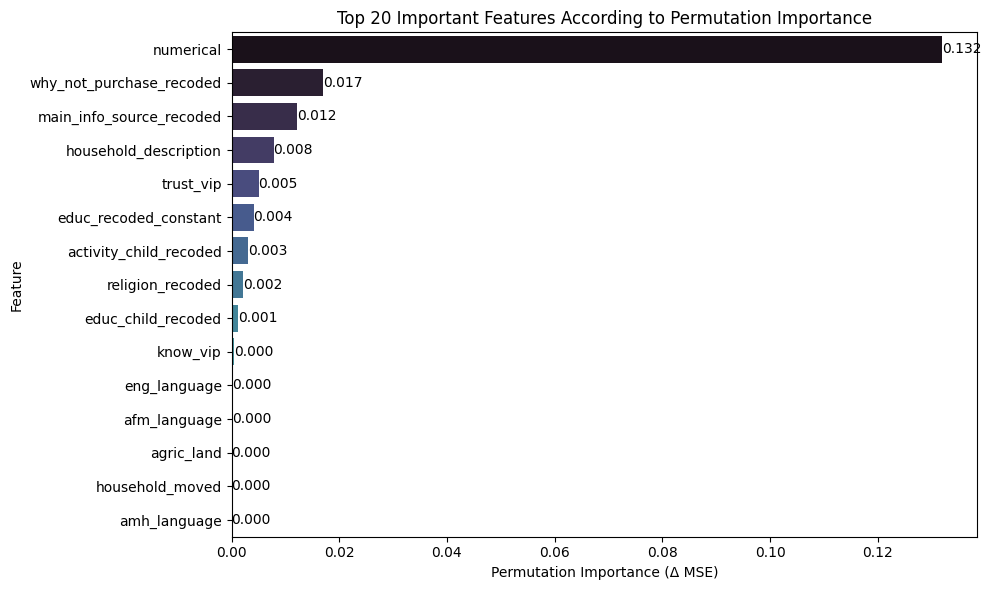

In [64]:
importance_df = pd.DataFrame(sorted_importance, columns=["Feature", "Importance"])
importance_df["Absolute Coefficient"] = importance_df["Importance"].abs()

# Top 20 features
top_features_df = importance_df.sort_values(by="Absolute Coefficient", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Absolute Coefficient", y="Feature", data=top_features_df, palette="mako")
plt.title("Top 20 Important Features According to Permutation Importance")
plt.xlabel("Permutation Importance (Δ MSE)")
plt.ylabel("Feature")

for i, value in enumerate(top_features_df["Absolute Coefficient"]):
    ax.text(value, i, f'{value:.3f}', color='black', va='center')

plt.tight_layout()
plt.savefig("top_features_permutation_importance_goat.png", dpi=300)
plt.show()